In [2]:
import matplotlib.pyplot as plt
import os
import sys
path = os.path.abspath('../..')  # points to celeste
if path not in sys.path:
    sys.path.insert(0, path)
print(path)

import numpy as np
import pytest
import torch

from celeste import device, use_cuda
from celeste import psf_transform
from celeste import train
from celeste import wake
from celeste.datasets import simulated_datasets
from celeste.models import sourcenet
from celeste.datasets.simulated_datasets import get_fitted_powerlaw_psf
from celeste.datasets.galaxy_datasets import DecoderSamples

/Users/zhezhao/Desktop/research/celeste


In [14]:
torch.manual_seed(60)

In [3]:
test_star = torch.load(os.path.abspath("../..")+"/data/3star_test_params")
test_image = test_star["images"]

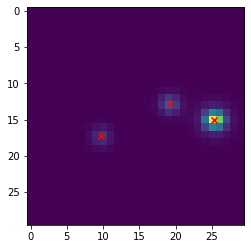

In [5]:
plt.imshow(test_image[0,0])
true_locs = test_star["locs"]
locs_x = true_locs[0][:,0].cpu().numpy() * (29)
locs_y = true_locs[0][:,1].cpu().numpy() * (29)
plt.scatter(locs_y, locs_x, marker='x', color='red')

In [6]:
# create training dataset
n_bands = 2
max_stars = 20
mean_stars = 10
min_stars = 5
f_min = 1e3
slen = 50

# set background
background = torch.zeros(n_bands, slen, slen, device=device)
background[0] = 686.0
background[1] = 1123.0

## initialize psf params, just add 4 to each sigmas
psf_file = path + "/data/fitted_powerlaw_psf_params.npy"
true_psf_params = torch.from_numpy(np.load(psf_file)).to(device)
print(true_psf_params)
true_psf = get_fitted_powerlaw_psf(psf_file)


init_psf_params = true_psf_params.clone()
init_psf_params[0, 1] += torch.tensor(4.0).to(device)
init_psf_params[1, 1] += torch.tensor(4.0).to(device)
init_psf = psf_transform.PowerLawPSF(init_psf_params).forward().detach()
print(init_psf_params)

galaxy_slen = 51
galaxy_decoder_file = path + "/data/decoder_params_100_single_band_i.dat"
single_band_galaxy_decoder = DecoderSamples(galaxy_slen, galaxy_decoder_file, n_bands=1)

# simulate dataset
n_images = 128*2
simulator_args = (
    single_band_galaxy_decoder,
    true_psf,
    background,
)

simulator_kwargs = dict(
    slen=slen,
    n_bands=n_bands,
    max_sources=max_stars,
    mean_sources=mean_stars,
    min_sources=min_stars,
    f_min=f_min,
    star_prob=1.0,  # enforce only stars are created in the training images.
)



tensor([[ -0.5396,   1.0622,   3.1312,   1.1505,  -2.1963, -16.2110],
        [ -0.3799,   0.7378,  -0.4502,   3.1473,  -1.2203,  -5.6375]])
tensor([[ -0.5396,   5.0622,   3.1312,   1.1505,  -2.1963, -16.2110],
        [ -0.3799,   4.7378,  -0.4502,   3.1473,  -1.2203,  -5.6375]])


In [57]:
dataset = simulated_datasets.SourceDataset(
    n_images, simulator_args, simulator_kwargs
)

# setup Star Encoder
star_encoder = sourcenet.SourceEncoder(
    slen=slen,
    ptile_slen=8,
    step=2,
    edge_padding=3,
    n_bands=n_bands,
    max_detections=2,
    n_source_params=n_bands,  # star has n_bands # fluxes
    enc_conv_c=5,
    enc_kern=3,
    enc_hidden=32
).to(device)

# train encoder
# training wrapper
SleepTraining = train.SleepTraining(
    model=star_encoder,
    dataset=dataset,
    slen=slen,
    n_bands=n_bands,
    n_source_params=n_bands,  # star has n_bands # fluxes
    verbose=True,
    batchsize=32,
)

n_epochs = 150 if use_cuda else 1
SleepTraining.run(n_epochs=n_epochs)

0 loss: 2.3344; counter loss: 0.7629; locs loss: 0.0267; source_params loss: 1.5448 	 [0.6 seconds]
1 loss: 1.2204; counter loss: 0.6591; locs loss: 0.0169; source_params loss: 0.5444 	 [0.6 seconds]
2 loss: 0.9227; counter loss: 0.5840; locs loss: 0.0159; source_params loss: 0.3229 	 [0.6 seconds]
3 loss: 0.7530; counter loss: 0.5248; locs loss: 0.0117; source_params loss: 0.2164 	 [0.6 seconds]
4 loss: 0.6505; counter loss: 0.4637; locs loss: 0.0074; source_params loss: 0.1793 	 [0.6 seconds]
5 loss: 0.5744; counter loss: 0.3985; locs loss: 0.0045; source_params loss: 0.1715 	 [0.6 seconds]
6 loss: 0.5023; counter loss: 0.3423; locs loss: 0.0038; source_params loss: 0.1562 	 [0.6 seconds]
7 loss: 0.4500; counter loss: 0.2958; locs loss: 0.0034; source_params loss: 0.1509 	 [0.6 seconds]
8 loss: 0.4078; counter loss: 0.2563; locs loss: 0.0026; source_params loss: 0.1489 	 [0.6 seconds]
9 loss: 0.3637; counter loss: 0.2231; locs loss: 0.0027; source_params loss: 0.1379 	 [0.6 seconds]


In [59]:
# get the estimated params
est_locs, est_source_params, est_n_sources = star_encoder.sample_encoder(
    test_image.to(device),
    n_samples=1,
    return_map_n_sources=True,
    return_map_source_params=True,
    training=False
)

# test that parameters match.
assert est_n_sources == test_star["n_sources"].to(device)

# locs
true_locs = test_star["locs"].to(device)
true_ind = true_locs.argsort(1)
true_ind = true_ind[0, :, 0]

est_locs = est_locs.to(device)
est_ind = est_locs.to(device).argsort(1)
est_ind = est_ind[0, :, 0]

diff_locs = true_locs[:, true_ind, :] - est_locs[:, est_ind, :]
diff_locs *= test_image.size(-1)
assert diff_locs.abs().max() <= 0.5

# fluxes
true_source_params = test_star["log_fluxes"][:, true_ind,].to(device)
est_source_params = est_source_params[:, est_ind, :].to(device)
diff = true_source_params - est_source_params
assert (diff.abs() <= est_source_params.abs() * 0.10).all()
assert (diff.abs() <= true_source_params.abs() * 0.10).all()

In [60]:
# Initialization
init_background_params = torch.zeros(2, 3, device=device)
init_background_params[0, 0] = 686.0
init_background_params[1, 0] = 1123.0

## make sure test background equals the initialization
init_background = wake.PlanarBackground(init_background_params, 30).forward()
assert torch.all(init_background == test_star["background"].to(device))

In [64]:
# run the wake-phase training
n_epochs = 1500 if use_cuda else 1

star_encoder.eval()
estimate_params, map_loss = wake.run_wake(
    test_image.to(device),
    star_encoder,
    init_psf_params,
    init_background_params,
    n_samples=100,
    n_epochs=n_epochs,
    lr=0.001,
    print_every=10,
    run_map=False,
)

[10] loss: 12440196.0000 	[0.3 seconds]
[20] loss: 12303584.0000 	[0.3 seconds]
[30] loss: 12167514.0000 	[0.3 seconds]
[40] loss: 12032015.0000 	[0.4 seconds]
[50] loss: 11897257.0000 	[0.3 seconds]
[60] loss: 11762680.0000 	[0.4 seconds]
[70] loss: 11629023.0000 	[0.3 seconds]
[80] loss: 11495513.0000 	[0.3 seconds]
[90] loss: 11363204.0000 	[0.3 seconds]
[100] loss: 11231338.0000 	[0.3 seconds]
[110] loss: 11099977.0000 	[0.3 seconds]
[120] loss: 10969154.0000 	[0.3 seconds]
[130] loss: 10839162.0000 	[0.3 seconds]
[140] loss: 10709464.0000 	[0.3 seconds]
[150] loss: 10581193.0000 	[0.3 seconds]
[160] loss: 10453686.0000 	[0.3 seconds]
[170] loss: 10326987.0000 	[0.3 seconds]
[180] loss: 10201944.0000 	[0.3 seconds]
[190] loss: 10077730.0000 	[0.3 seconds]
[200] loss: 9954768.0000 	[0.3 seconds]
[210] loss: 9832230.0000 	[0.3 seconds]
[220] loss: 9710400.0000 	[0.3 seconds]
[230] loss: 9589492.0000 	[0.3 seconds]
[240] loss: 9469416.0000 	[0.3 seconds]
[250] loss: 9350776.0000 	[0.3

In [65]:
estimate_psf_params = list(estimate_params.power_law_psf.parameters())[0]
print(true_psf_params)
print(init_psf_params)
print(estimate_psf_params)

tensor([[ -0.5396,   1.0622,   3.1312,   1.1505,  -2.1963, -16.2110],
        [ -0.3799,   0.7378,  -0.4502,   3.1473,  -1.2203,  -5.6375]],
       device='cuda:0')
tensor([[ -0.5396,   5.0622,   3.1312,   1.1505,  -2.1963, -16.2110],
        [ -0.3799,   4.7378,  -0.4502,   3.1473,  -1.2203,  -5.6375]],
       device='cuda:0')
Parameter containing:
tensor([[  0.1660,   3.9343,   2.0950,   2.0348,  -3.2571, -17.2433],
        [  0.4386,   3.5245,   0.4301,   3.7356,  -2.4005,  -3.9934]],
       device='cuda:0', requires_grad=True)


In [66]:
estimate_psf = psf_transform.PowerLawPSF(estimate_psf_params).forward().detach()
torch.all(estimate_psf >= 0)

tensor(True, device='cuda:0')

tensor(0.)


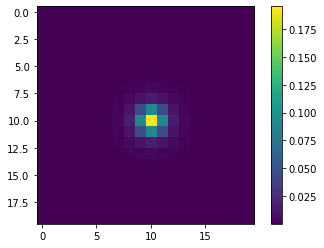

In [67]:
true_psf = psf_transform.PowerLawPSF(true_psf_params).forward().detach()
init_psf = psf_transform.PowerLawPSF(init_psf_params).forward().detach()
print(true_psf.cpu().min())
plt.imshow(true_psf.cpu()[0, 40:60, 40:60])
plt.colorbar()

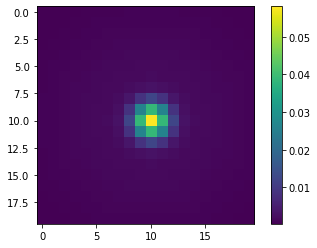

In [68]:
plt.imshow((estimate_psf).cpu()[0, 40:60, 40:60])
plt.colorbar()

In [52]:
init_residual = (true_psf - init_psf).abs().to(device)
trained_residual = (true_psf - estimate_psf).abs().to(device)
print(trained_residual.sum())
print(init_residual.sum())
assert trained_residual.sum() <= init_residual.sum() * 0.10

tensor(1.7630, device='cuda:0')
tensor(3.3362, device='cuda:0')


AssertionError: 